https://pypi.org/project/tweet-preprocessor/

In [160]:
import os
import sys
import socket
import re
import numpy as np
import string
import warnings
from timeit import default_timer as timer
from datetime import datetime
from glob import glob
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import scipy as sp

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,desc,row_number,col,year,month,dayofmonth,dayofweek,to_timestamp,size,isnan,lit,lower,date_format,countDistinct
import pyspark.sql.functions as F
from pyspark.sql.types import MapType, StringType, IntegerType, StructType, StructField, FloatType, ArrayType

from geospark.register import GeoSparkRegistrator
from geospark.utils import GeoSparkKryoRegistrator, KryoSerializer
from geospark.register import upload_jars
from geospark.utils.adapter import Adapter

In [2]:
country_code='PK'

In [3]:
upload_jars()

try:
    spark
except NameError:
    print('Create Spark')
    spark=SparkSession.builder.appName("").config(
    "spark.serializer", KryoSerializer.getName).config(
    "spark.kryo.registrator", GeoSparkKryoRegistrator.getName).getOrCreate()
    
GeoSparkRegistrator.registerAll(spark)

Create Spark


True

In [4]:
if os.getenv('CLUSTER')=='PRINCE':
    path_to_data='/scratch/spf248/twitter/data'
else:
    path_to_data='/user/spf248/twitter/data'

# List data files
path_to_timelines=os.path.join(path_to_data,'timelines','extract',country_code)
fs=spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
list_status=fs.listStatus(spark._jvm.org.apache.hadoop.fs.Path(path_to_timelines))
paths=[file.getPath().toString().replace('hdfs://dumbo','').replace('file:','') for file in list_status]
paths=[path for path in paths if '.parquet' in path]

In [5]:
if os.getenv('CLUSTER')=='PRINCE':
    df=spark.read.parquet(paths[0])
else:
    df=spark.read.parquet(path_to_timelines)

In [6]:
df.cache()

DataFrame[tweet_id: string, created_at: timestamp, text: string, tweet_lang: string, user_id: string, user_location: string, place_id: string, tweet_longitude: string, tweet_latitude: string]

In [7]:
print('#Tweets:',df.count())
print('#Users:',df.select("user_id").distinct().count())

#Tweets: 1378559
#Users: 248946


In [8]:
df=df.withColumn("date", date_format(col("created_at"), "yyyy-MM"))

# Summary

In [9]:
n_users_date=df.groupby("date").agg(countDistinct("user_id")).withColumnRenamed("count(DISTINCT user_id)","n_users").orderBy('date')
n_users_location=df.groupBy('user_location').agg(countDistinct("user_id")).withColumnRenamed("count(DISTINCT user_id)","n_users").orderBy(desc('n_users'))
n_tweets_language=df.groupBy('tweet_lang').count().withColumnRenamed("count","n_tweets").orderBy(desc('n_tweets'))
word_counts=df.withColumn('word', F.explode(F.split(lower(F.col('text')), ' '))).groupBy('word').count().sort(desc('count'))
hashtags=word_counts.where(word_counts['word'].contains('#'))

In [10]:
n_users_date.write.mode("overwrite").parquet(os.path.join(path_to_data,'reports',country_code,'n_users_date'))
n_users_location.write.mode("overwrite").parquet(os.path.join(path_to_data,'reports',country_code,'n_users_location'))
n_tweets_language.write.mode("overwrite").parquet(os.path.join(path_to_data,'reports',country_code,'n_tweets_language'))
word_counts.write.mode("overwrite").parquet(os.path.join(path_to_data,'reports',country_code,'word_counts'))
hashtags.write.mode("overwrite").parquet(os.path.join(path_to_data,'reports',country_code,'hashtags'))

# Co-occurences

In [11]:
pashto=[
'تاوتریخوالی',
'مقاومت',
'پښتنې',
'جرګه',
'له بشري حقونو څخه سرغړونه',
'لیویز ځواک',
'طبیعي سرچینې',
'مشران',
'بادل',
'سیاسي فعالیت',
'افریدی',
'تروریزم',
'محسن داور',
'علي وزیر']

urdu=['تشدد',
'مزاحمت',
'پشتون',
'جرگہ',
'انسانی حقوق کی پامالی',
'لیویز فورس',
'قدرتی وسائل',
'بزرگ',
'معافی اور پناہ',
'سیاسی سرگرمی',
'آفریدی',
'دہشت گردی',
'محسن داوڑ',
'علی وزیر']

english=['violence',
'resistance',
'pashtun',
'jirga',
'human rights abuse',
'levies force',
'natural resource',
'masharaan',
'badal',
'political activism',
'afridi',
'terrorism',
'mohsin dawar',
'ali wazir']

word_counts.cache()

DataFrame[word: string, count: bigint]

In [18]:
def cooccurrences(keyword,language,idx):
    tweets=df.filter(lower(df["text"]).contains(keyword)).select('tweet_id','text')
    tweets.write.mode("overwrite").parquet(os.path.join(path_to_data,'reports',country_code,'tweets',str(idx)+'_'+language))
    words=tweets.withColumn('word', F.explode(F.split(lower(F.col('text')), ' '))).groupBy('word').count().sort(desc('count'))
    words=words.join(word_counts.withColumnRenamed('count','N'),on='word')
    words=words.withColumn("pct", (F.col("count") / F.col("N"))).sort(desc('pct'))
    words.write.mode("overwrite").parquet(os.path.join(path_to_data,'reports',country_code,'coocurrences',str(idx)+'_'+language))
    
for idx,keyword in enumerate(pashto):
    print(idx,keyword)
    cooccurrences(keyword,'pashto',idx)
for idx,keyword in enumerate(urdu):
    print(idx,keyword)
    cooccurrences(keyword,'urdu',idx)
for idx,keyword in enumerate(english):
    print(idx,keyword)
    cooccurrences(keyword,'english',idx)

0 تاوتریخوالی
1 مقاومت
2 پښتنې
3 جرګه
4 له بشري حقونو څخه سرغړونه
5 لیویز ځواک
6 طبیعي سرچینې
7 مشران
8 بادل
9 سیاسي فعالیت
10 افریدی
11 تروریزم
12 محسن داور
13 علي وزیر
0 تشدد
1 مزاحمت
2 پشتون
3 جرگہ
4 انسانی حقوق کی پامالی
5 لیویز فورس
6 قدرتی وسائل
7 بزرگ
8 معافی اور پناہ
9 سیاسی سرگرمی
10 آفریدی
11 دہشت گردی
12 محسن داوڑ
13 علی وزیر
0 violence
1 resistance
2 pashtun
3 jirga
4 human rights abuse
5 levies force
6 natural resource
7 masharaan
8 badal
9 political activism
10 afridi
11 terrorism
12 mohsin dawar
13 ali wazir


# Spatial Join

In [13]:
path_to_shp=os.path.join(path_to_data,'shp')
admin=spark.read.option("header", "true").csv(os.path.join(path_to_shp,country_code+'.csv'))
admin.createOrReplaceTempView("admin")
query="select "
for col in admin.columns:
    if col!='_c0' and col!='geometry':
        query+="admin."+col+" as "+col+", "
query+="ST_GeomFromText(admin.geometry) as polygon from admin"
admin=spark.sql(query)
admin.createOrReplaceTempView("admin")
admin.cache()
print('# Admin Units:',admin.count())

# Admin Units: 141


In [14]:
points=df.where(df["tweet_latitude"].isNotNull())
points.createOrReplaceTempView("points")
query="select "
for col in points.columns:
    query+="points."+col+" as "+col+", "
query+="ST_Point(cast(points.tweet_longitude as Decimal(24,20)), cast(points.tweet_latitude as Decimal(24,20))) as point from points"
points=spark.sql(query)
points.createOrReplaceTempView("points")

In [15]:
query="SELECT "
for col in points.columns:
    if col!='point':
        query+="p."+col+", "
for col in admin.columns:
    if col!='polygon':
        query+="a."+col+", "
query=query[:-2]+" FROM points AS p, admin AS a WHERE ST_Intersects(p.point, a.polygon)"
points_geocoded=spark.sql(query)

In [16]:
points_geocoded.write.mode("overwrite").parquet(os.path.join(path_to_data,'reports',country_code,'points_geocoded'))

# Summary Stats

In [ ]:
n_users_date.write.mode("overwrite").parquet(os.path.join(path_to_data,'reports',country_code,'n_users_date'))
n_users_location.write.mode("overwrite").parquet(os.path.join(path_to_data,'reports',country_code,'n_users_location'))
n_tweets_language.write.mode("overwrite").parquet(os.path.join(path_to_data,'reports',country_code,'n_tweets_language'))
word_counts.write.mode("overwrite").parquet(os.path.join(path_to_data,'reports',country_code,'word_counts'))
hashtags.write.mode("overwrite").parquet(os.path.join(path_to_data,'reports',country_code,'hashtags'))

In [20]:
print('Import')
start = timer()
data_dir = Path(os.path.join(path_to_data,'reports',country_code,'n_users_date'))
n_users_date = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")  

Import
Done in 10 sec


In [22]:
print('Import')
start = timer()
data_dir = Path(os.path.join(path_to_data,'reports',country_code,'n_users_location'))
n_users_location = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")  

Import
Done in 1 sec


In [23]:
print('Import')
start = timer()
data_dir = Path(os.path.join(path_to_data,'reports',country_code,'n_tweets_language'))
n_tweets_language = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")  

Import
Done in 1 sec


In [60]:
print('Import')
start = timer()
data_dir = Path(os.path.join(path_to_data,'reports',country_code,'hashtags'))
hashtags = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")  

Import
Done in 11 sec


In [35]:
end_date='12/31/2019'
n_users_date.date=pd.to_datetime(n_users_date.date)
n_users_date=n_users_date.set_index('date')['n_users']
n_users_date=n_users_date.sort_index().truncate(after=end_date)

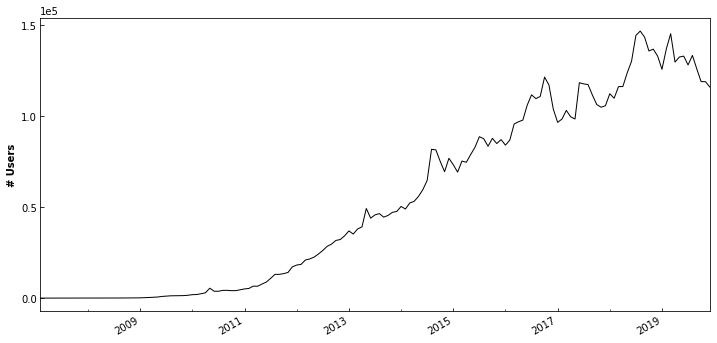

In [80]:
fig,ax=plt.subplots(figsize=(12,6))
n_users_date.plot(ax=ax,linewidth=1,color='k')
ax.tick_params(which='both',direction='in',pad=3)
ax.locator_params(axis='y',nbins=6)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xlabel('')
ax.set_ylabel('# Users',fontweight='bold')
fig.autofmt_xdate()
plt.savefig(os.path.join(path_to_data,'reports',country_code,'fig','n_users.pdf'),bbox_inches='tight')

In [93]:
n_tweets_language.set_index('tweet_lang').sum()

n_tweets    275850653
dtype: int64

In [87]:
n_users_location=n_users_location.set_index('user_location')['n_users'].sort_values(ascending=False)

In [88]:
n_users_location.sum()

614263

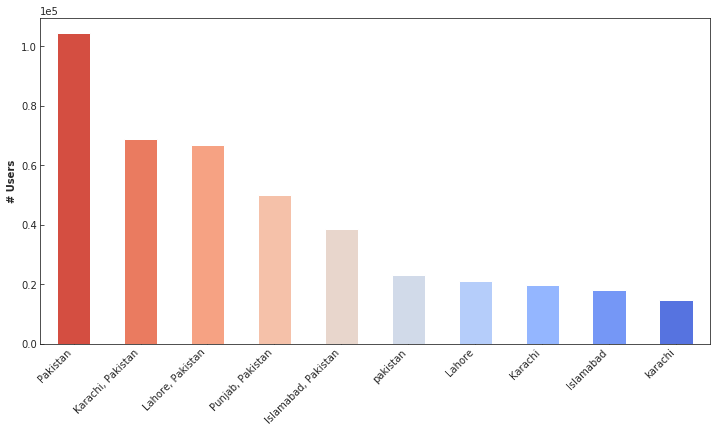

In [91]:
with sns.axes_style("white"):
    sns.set_style("ticks")
    fig,ax = plt.subplots(figsize=(12,6))
    data_to_plot=n_users_location.head(10)
    data_to_plot.plot(ax=ax,kind='bar',color=sns.color_palette("coolwarm", 10)[::-1])
    ax.set_ylabel('# Users',fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(which='both',direction='in',pad=3)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
plt.savefig(os.path.join(path_to_data,'reports',country_code,'fig','user_locations.pdf'),bbox_inches='tight')

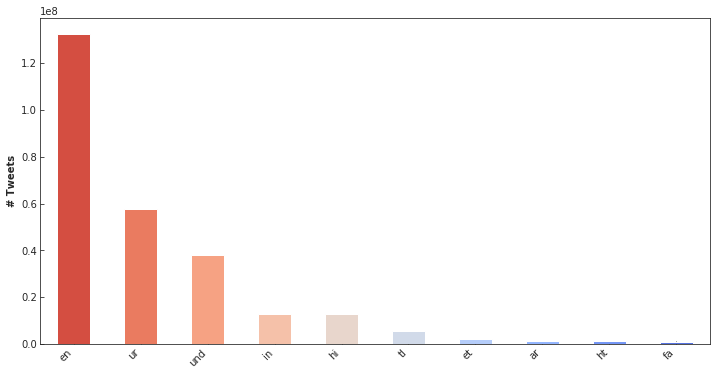

In [81]:
with sns.axes_style("white"):
    sns.set_style("ticks")
    fig,ax = plt.subplots(figsize=(12,6))
    data_to_plot=n_tweets_language.dropna().set_index('tweet_lang')['n_tweets'].sort_values(ascending=False).head(10)
    data_to_plot.plot(ax=ax,kind='bar',color=sns.color_palette("coolwarm", 10)[::-1])
    ax.set_ylabel('# Tweets',fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(which='both',direction='in',pad=3)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
plt.savefig(os.path.join(path_to_data,'reports',country_code,'fig','languages.pdf'),bbox_inches='tight')

In [ ]:
hashtags=hashtags.set_index('word')['count'].sort_values(ascending=False)

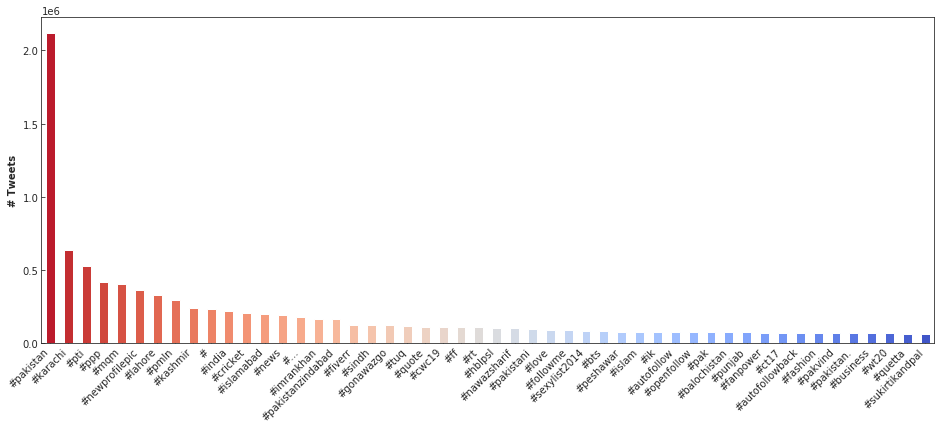

In [83]:
with sns.axes_style("white"):
    sns.set_style("ticks")
    fig,ax = plt.subplots(figsize=(16,6))
    data_to_plot=hashtags.head(50)
    data_to_plot.plot(ax=ax,kind='bar',color=sns.color_palette("coolwarm", 50)[::-1])
    ax.set_ylabel('# Tweets',fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(which='both',direction='in',pad=3)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.locator_params(axis='y',nbins=6)
#     ax.set_yscale('log')
plt.savefig(os.path.join(path_to_data,'reports',country_code,'fig','hashtags.pdf'),bbox_inches='tight')

# Examples of tweets and cooccurrences

In [281]:
idx=0
language='english'
keyword=english[idx]
filename=[x for x in glob(os.path.join(path_to_data,'reports',country_code,'tweets','*')) if language in x and '/'+str(idx)+'_' in x][0]

In [282]:
print('Import')
start = timer()
data_dir = Path(filename)
tweets = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")  

Import
Done in 14 sec


In [287]:
print(keyword,':\n')
print('\n\n'.join(tweets['text'].replace('\n','').head(10)))

violence :

In Pakistan, schools aiming for equal girls' enrollment will face many challenges. 2 of the greatest such challenges are #violence and the onset of #adolescence.

#CacheWednesday #FromTheArchives #Education #GenderEquality 
@TCFPak @UNGEI @ayeshanorakhan
https://t.co/oFhQjj2FfK https://t.co/ttyxvBkvrb

Report violence reduce violence against women. ✌🏻 https://t.co/ZWoStYHp0l

RT @gabeeno: PTI is a radical party that supports hate and violence , whoever is planning to vote for PTI , please understand how dangerous…

RT @OzerKhalid: Take Action NOW
Online #Misogyny rabidly contravenes:
#Pakistan`s electronic violence against #women (e-VAW)
Cybercrime Bil…

To @Spotlight_VAWG → feminists recommend that you deliberately support, leverage, and strengthen existing and emerging feminist movements, both nationally and transnationally, in order to succeed in your important mission to end gender-based violence #SpotlightEndViolence #EDD18

RT @cafreeland: Appalled by the abhorrent st

In [305]:
idx=0
language='english'
keyword=english[idx]
filename=[x for x in glob(os.path.join(path_to_data,'reports',country_code,'coocurrences','*')) if language in x and '/'+str(idx)+'_' in x][0]

In [320]:
print('Import')
start = timer()
data_dir = Path(filename)
coocurrences = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")  

Import
Done in 1 sec


In [316]:
def clean_tweet(x):
    return re.sub(r"""
    [,.;@#?!&$"\n]+  # Accept one or more copies of punctuation
    \ *           # plus zero or more copies of a space,
    """,
    " ",          # and replace it with a single space
    x, flags=re.VERBOSE)

In [322]:
coocurrences=coocurrences.loc[coocurrences['word'].apply(lambda x:keyword not in x)].copy()
coocurrences['word']=coocurrences['word'].apply(lambda x:re.sub(r'[^\w\s]','',x))
coocurrences=coocurrences.groupby('word')[['count','N']].sum()
coocurrences['pct']=coocurrences['count'].divide(coocurrences['N'])

# Geocoded Tweets

In [187]:
print('Import')
start = timer()
data_dir = Path(os.path.join(path_to_data,'reports',country_code,'points_geocoded'))
points_geocoded = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")  

Import
Done in 27 sec


In [250]:
shp=admin.toPandas()
shp=gpd.GeoDataFrame(shp,geometry='polygon')
id2admin=points_geocoded.groupby('user_id')['ID_3'].agg(lambda x: sp.stats.mode(x)[0])
shp=shp.merge((id2admin.reset_index().groupby('ID_3')['user_id'].count()).reset_index())
shp['pct_users']=shp['user_id']/id2admin.shape[0]*100

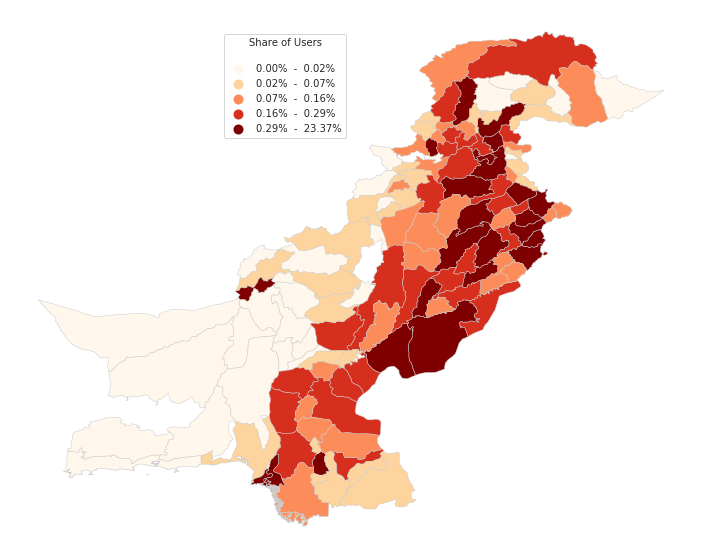

In [269]:
with sns.axes_style("white"):
    sns.set_style("ticks")
    
    fig,ax = plt.subplots(figsize=(20,10))

    plot=shp.plot(
    'pct_users',
    scheme='Quantiles',
    linewidth=0.5, 
    k=5,
    ax=ax, 
    cmap='OrRd',
    edgecolor='0.8',
    legend=True,
    legend_kwds={
    'frameon': True, 
    'title': 'Share of Users\n',
    'loc': 'lower right',
    'bbox_to_anchor':(0.5, 0.75), 
    })
    ax.axis('off')
    leg = plot.get_legend()
    for lbl in leg.get_texts():
        label_text = lbl.get_text()
        lower = label_text.split()[0]
        upper = label_text.split()[2]
        new_text = f'{float(lower):,.2f}%  -  {float(upper):,.2f}%'
        lbl.set_text(new_text)

plt.savefig(os.path.join(path_to_data,'reports',country_code,'fig','map-users.pdf'),bbox_inches='tight')

In [267]:
(100*shp.groupby('NAME_1')['user_id'].sum()/id2admin.shape[0]).sort_values(ascending=False).round(2).to_csv(os.path.join(path_to_data,'reports',country_code,'fig','users-admin-1.csv'))